### ***Contributed by:-***

Divyanshi Bhojak(202IT007)

Tarushi Jat (202IT029)

### ***Description:*** 

Classification with SVHN dataset using Fixed Learning Rate VGG16 Architecture.
****

### **Libraries Used**

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import pandas as pd

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
import seaborn as sns
from keras import regularizers
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
plt.style.use('ggplot')

### **Defining AdamW Optimizer**

In [ ]:
class Optimizer:
    def __init__(self, learning_rate=None, name=None):
        self.learning_rate = learning_rate
        self.name = name

    def config(self, layers):
        # sets up empty cache dictionaries 
        pass

    def optimize(self, idx, layers: list, grads: dict, *args):
        
        pass 

In [ ]:
class AdamW(Adam):  
    
    def __init__(self, learning_rate, gamma_init=1e-5, decay_rate=0.8, **kwargs):
        super().__init__(**kwargs)
        self.learning_rate = learning_rate
        self.gamma_init = gamma_init
        self.decay_rate = decay_rate
    
    def optimize(self, idx, layers, grads, epoch_num, steps):
        gamma = self.gamma_init * self.decay_rate ** int(epoch_num / 5) 
        dW = grads[f'dW{idx}']
        db = grads[f'db{idx}']
        self.m[f'W{idx}'] = self.beta1 * self.m[f'W{idx}'] + (1 - self.beta1) * dW
        self.v[f'W{idx}'] = self.beta2 * self.v[f'W{idx}'] + (1 - self.beta2) * dW ** 2 

        self.m[f'b{idx}'] = self.beta1 * self.m[f'b{idx}'] + (1 - self.beta1) * db
        self.v[f'b{idx}'] = self.beta2 * self.v[f'b{idx}'] + (1 - self.beta2) * db ** 2 

        mt_w  = self.m[f'W{idx}'] / (1 - self.beta1 ** steps)
        vt_w = self.v[f'W{idx}'] / (1 - self.beta2 ** steps)

        mt_b  = self.m[f'b{idx}'] / (1 - self.beta1 ** steps)
        vt_b = self.v[f'b{idx}'] / (1 - self.beta2 ** steps)

        w_update = - self.learning_rate * mt_w / ((np.sqrt(vt_w) + self.epsilon) + gamma * layers[idx].W) 
        b_update = - self.learning_rate * mt_b / ((np.sqrt(vt_b) + self.epsilon) + gamma * layers[idx].b)

        layers[idx].W += w_update
        layers[idx].b += b_update


### **SVHN Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Method for Loading, Pre-processing & Splitting Dataset**

In [ ]:
def svhn_data_split():
    x_train = sio.loadmat("/content/drive/MyDrive/Projects/SVHM/train_32x32.mat")['X'] 
    y_train = sio.loadmat("/content/drive/MyDrive/Projects/SVHM/train_32x32.mat")['y']
    x_test = sio.loadmat("/content/drive/MyDrive/Projects/SVHM/test_32x32.mat")['X']
    y_test = sio.loadmat("/content/drive/MyDrive/Projects/SVHM/test_32x32.mat")['y']
    
    img_rows, img_cols = 32, 32
    num_classes = 10 

    X_train = []
    for i in range(x_train.shape[3]):
        X_train.append(x_train[:,:,:,i])
    X_train = np.asarray(X_train)
    
    X_test = []
    for i in range(x_test.shape[3]):
        X_test.append(x_test[:,:,:,i])
    X_test = np.asarray(X_test)

    y_test1 = y_test.reshape((26032, ))
    y_test1 = [y-1 for y in y_test1]
    y_train1 = y_train.reshape((73257, ))
    y_train1 = [y-1 for y in y_train1]    
    
    input_shape = (img_rows, img_cols, 3)
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    X_train /= 255
    X_test /= 255
    print('x_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    
    y_train2 = keras.utils.to_categorical(y_train1, num_classes)
    y_test2 = keras.utils.to_categorical(y_test1, num_classes)
    
    y_train2 = y_train2.astype('int32')
    y_test2 = y_test2.astype('int32')

    
    print("after process: X train shape: {}, X test shape: {}, y train shape: {}, y test shape: {}".format(x_train.shape, x_test.shape, y_train2.shape, y_test2.shape))
    return  input_shape, X_train, X_test, y_train2, y_test2

### **Performance Metrics Used**
1. Computation & cost time
2. Accuracy
3. Confusion Matrix
4. Classification Report

In [ ]:
def perf_metrics_acc(model):
  score = model.evaluate(x_test,y_test,verbose=0)
  print("Test Loss : {:.4f}".format(score[0]))
  print("Test Accuracy : {:.2f}".format(score[1]*100),"%")

In [ ]:
def per_metrics_2(y_test, pred):
  print("*******************Classification Report*******************\n")
  print(classification_report(y_test, pred))
  print("*******************Confusion Matrix*******************\n")
  print(confusion_matrix(y_test, pred))

### **Plotting Graph Methods**

In [ ]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def display_cm(y_test, model_pred):
  CM = confusion_matrix(y_test, model_pred)
  f, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()

### **VGG16 Architecture with Transfer Learning**

In [ ]:
def vgg_model():
  weight_decay = 0.0005
  x_shape = [32,32,3]

  model = Sequential()

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_shape, kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))) 
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Dropout(0.5))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  return model

### **VGG16 Model Summary**

In [ ]:
model = vgg_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

### **Training Model with Adam Optimizer**

In [ ]:
input_shape, x_train, x_test, y_train, y_test = svhn_data_split()

x_train shape: (73257, 32, 32, 3)
73257 train samples
26032 test samples
after process: X train shape: (32, 32, 3, 73257), X test shape: (32, 32, 3, 26032), y train shape: (73257, 10), y test shape: (26032, 10)


In [ ]:
model1 = vgg_model()
opt = keras.optimizers.Adam(lr=0.001)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
vgg_adam = model1.fit(x_train, y_train, batch_size=500, epochs=50, validation_data=(x_test, y_test), shuffle=True)   #Original Epoch = 50

Epoch 1/50
147/147 [==============================] - 80s 297ms/step - loss: 5.1747 - accuracy: 0.1306 - val_loss: 4.4750 - val_accuracy: 0.1959
Epoch 2/50
147/147 [==============================] - 40s 275ms/step - loss: 4.3823 - accuracy: 0.2080 - val_loss: 44.5403 - val_accuracy: 0.1959
Epoch 3/50
147/147 [==============================] - 40s 276ms/step - loss: 3.4893 - accuracy: 0.3734 - val_loss: 2.8659 - val_accuracy: 0.5432
Epoch 4/50
147/147 [==============================] - 41s 277ms/step - loss: 2.1047 - accuracy: 0.7993 - val_loss: 1.7988 - val_accuracy: 0.8341
Epoch 5/50
147/147 [==============================] - 41s 278ms/step - loss: 1.6037 - accuracy: 0.8812 - val_loss: 1.4219 - val_accuracy: 0.8945
Epoch 6/50
147/147 [==============================] - 41s 278ms/step - loss: 1.3301 - accuracy: 0.8994 - val_loss: 1.1637 - val_accuracy: 0.9126
Epoch 7/50
147/147 [==============================] - 41s 280ms/step - loss: 1.1344 - accuracy: 0.9111 - val_loss: 1.0278 - val_a

### **Performance Metrics Analysis for Model with Adam Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model1)

Test Loss : 0.6751
Test Accuracy : 94.37 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model1.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5099
           1       0.97      0.95      0.96      4149
           2       0.96      0.90      0.93      2882
           3       0.98      0.94      0.96      2523
           4       0.88      0.97      0.92      2384
           5       0.95      0.92      0.94      1977
           6       0.89      0.96      0.93      2019
           7       0.96      0.91      0.93      1660
           8       0.91      0.94      0.93      1595
           9       0.96      0.94      0.95      1744

    accuracy                           0.94     26032
   macro avg       0.94      0.94      0.94     26032
weighted avg       0.95      0.94      0.94     26032

*******************Confusion Matrix*******************

[[4937   18   10   30   13    6   67    4    3   11]
 [  27 3941   32    3   28    2  106    2    6    2]
 [  32   36 2593  

**3. Visualizing accuracy for every epoch**

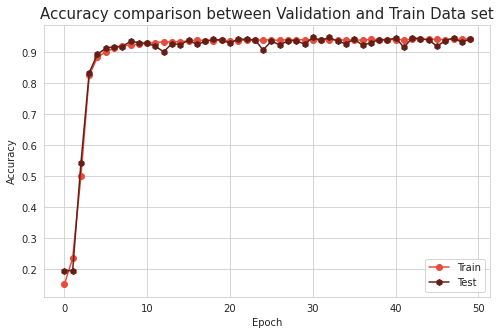

In [ ]:
acc_plot(vgg_adam)

**4. Visualizing loss in every epoch**

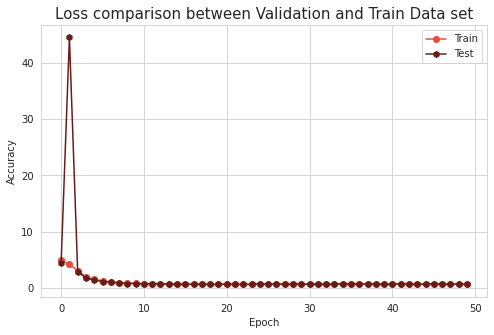

In [ ]:
loss_plot(vgg_adam)

**5. Visualizing Confusion Matrix**

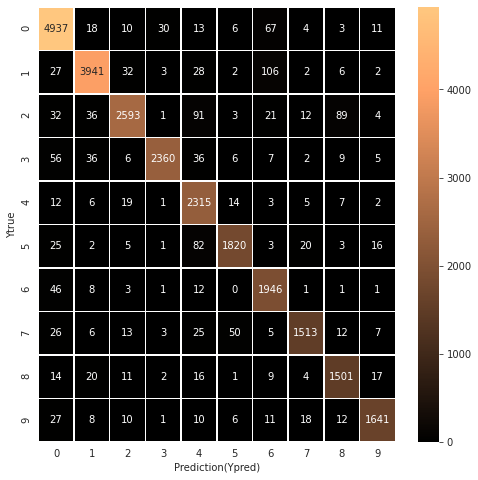

In [ ]:
display_cm(y_test, pred)

**6. Roc Curve**

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
y_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_bin.shape[1]
y_pred = label_binarize(pred, classes=[0,1,2,3,4,5,6,7,8,9])

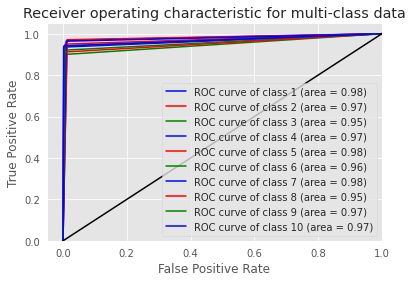

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### **Training Model with SGD-M Optimizer**

In [ ]:
input_shape, x_train, x_test, y_train, y_test = svhn_data_split()

x_train shape: (73257, 32, 32, 3)
73257 train samples
26032 test samples
after process: X train shape: (32, 32, 3, 73257), X test shape: (32, 32, 3, 26032), y train shape: (73257, 10), y test shape: (26032, 10)


In [ ]:
model2 = vgg_model()
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=False)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
vgg_sgdm = model2.fit(x_train, y_train, batch_size=500, epochs=100, validation_data=(x_test, y_test), shuffle=True)   #Original Epochs = 100

Epoch 1/100
147/147 [==============================] - 43s 276ms/step - loss: 5.5645 - accuracy: 0.1013 - val_loss: 4.4608 - val_accuracy: 0.1959
Epoch 2/100
147/147 [==============================] - 40s 276ms/step - loss: 4.9631 - accuracy: 0.1192 - val_loss: 4.4464 - val_accuracy: 0.1959
Epoch 3/100
147/147 [==============================] - 40s 275ms/step - loss: 4.8230 - accuracy: 0.1415 - val_loss: 4.4304 - val_accuracy: 0.1958
Epoch 4/100
147/147 [==============================] - 41s 276ms/step - loss: 4.7301 - accuracy: 0.1604 - val_loss: 4.4149 - val_accuracy: 0.1962
Epoch 5/100
147/147 [==============================] - 41s 276ms/step - loss: 4.6705 - accuracy: 0.1688 - val_loss: 4.4049 - val_accuracy: 0.1959
Epoch 6/100
147/147 [==============================] - 41s 278ms/step - loss: 4.6231 - accuracy: 0.1756 - val_loss: 4.3993 - val_accuracy: 0.1961
Epoch 7/100
147/147 [==============================] - 41s 278ms/step - loss: 4.5669 - accuracy: 0.1867 - val_loss: 4.3951 -

**6. Roc Curve**

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
y_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_bin.shape[1]
y_pred = label_binarize(pred, classes=[0,1,2,3,4,5,6,7,8,9])

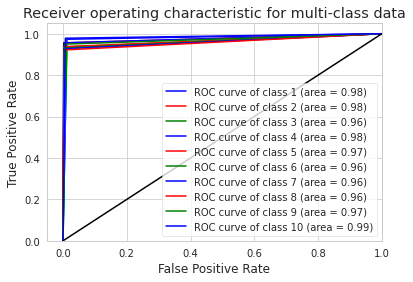

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### **Performance Metrics Analysis for Model with SGD-M Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model2)

Test Loss : 1.8985
Test Accuracy : 93.98 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model2.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5099
           1       0.98      0.95      0.96      4149
           2       0.93      0.90      0.91      2882
           3       0.98      0.93      0.96      2523
           4       0.95      0.94      0.95      2384
           5       0.91      0.95      0.93      1977
           6       0.94      0.94      0.94      2019
           7       0.91      0.90      0.90      1660
           8       0.86      0.93      0.90      1595
           9       0.90      0.97      0.93      1744

    accuracy                           0.94     26032
   macro avg       0.93      0.94      0.93     26032
weighted avg       0.94      0.94      0.94     26032

*******************Confusion Matrix*******************

[[4902   14   33   22    9    9   44    9    6   51]
 [  29 3932   66    8    5    9   44   14   31   11]
 [  37   13 2583  

**3. Visualizing accuracy for every epoch**

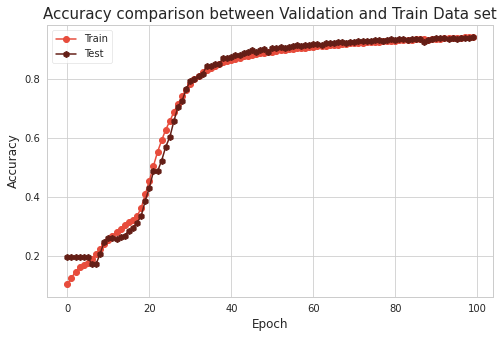

In [ ]:
acc_plot(vgg_sgdm)

**4. Visualizing loss in every epoch**

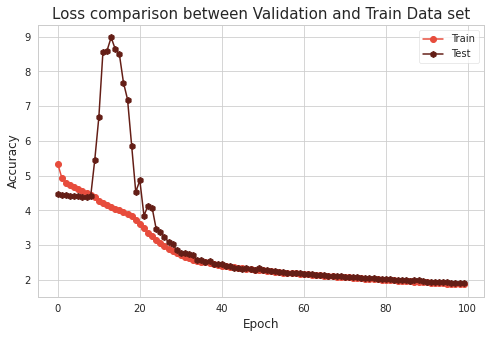

In [ ]:
loss_plot(vgg_sgdm)

**5. Visualizing Confusion Matrix**

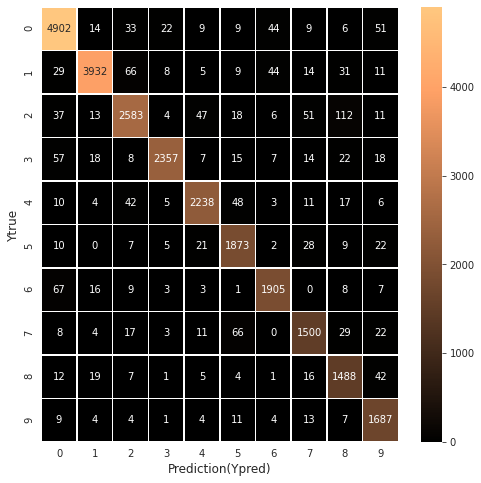

In [ ]:
display_cm(y_test, pred)

### **Training Model with Adam-Weight Decay Optimizer**

In [ ]:
input_shape, x_train, x_test, y_train, y_test = svhn_data_split()

x_train shape: (73257, 32, 32, 3)
73257 train samples
26032 test samples
after process: X train shape: (32, 32, 3, 73257), X test shape: (32, 32, 3, 26032), y train shape: (73257, 10), y test shape: (26032, 10)


In [ ]:
model3 = vgg_model()
model3.compile(loss='categorical_crossentropy', optimizer=AdamW(0.001), metrics=['accuracy'])

In [ ]:
vgg_adamW = model3.fit(x_train, y_train, batch_size=500, epochs=50, validation_data=(x_test, y_test), shuffle=True)  #Original Epochs = 50

Epoch 1/50
147/147 [==============================] - 44s 282ms/step - loss: 5.2001 - accuracy: 0.1167 - val_loss: 4.4126 - val_accuracy: 0.1959
Epoch 2/50
147/147 [==============================] - 41s 281ms/step - loss: 4.5605 - accuracy: 0.1861 - val_loss: 4.3526 - val_accuracy: 0.1622
Epoch 3/50
147/147 [==============================] - 41s 281ms/step - loss: 3.8711 - accuracy: 0.3264 - val_loss: 5.8001 - val_accuracy: 0.3555
Epoch 4/50
147/147 [==============================] - 41s 280ms/step - loss: 2.8119 - accuracy: 0.6776 - val_loss: 2.5614 - val_accuracy: 0.7935
Epoch 5/50
147/147 [==============================] - 41s 281ms/step - loss: 2.2061 - accuracy: 0.8383 - val_loss: 2.4026 - val_accuracy: 0.8700
Epoch 6/50
147/147 [==============================] - 41s 280ms/step - loss: 1.9271 - accuracy: 0.8784 - val_loss: 1.9309 - val_accuracy: 0.9035
Epoch 7/50
147/147 [==============================] - 41s 281ms/step - loss: 1.7158 - accuracy: 0.8964 - val_loss: 1.8424 - val_ac

### **Performance Metrics Analysis for Model with AdamW Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model3)

Test Loss : 0.5844
Test Accuracy : 95.03 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model3.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5099
           1       0.98      0.96      0.97      4149
           2       0.94      0.95      0.94      2882
           3       0.96      0.96      0.96      2523
           4       0.97      0.94      0.95      2384
           5       0.94      0.95      0.95      1977
           6       0.93      0.96      0.94      2019
           7       0.93      0.95      0.94      1660
           8       0.94      0.92      0.93      1595
           9       0.93      0.97      0.95      1744

    accuracy                           0.95     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.95      0.95      0.95     26032

*******************Confusion Matrix*******************

[[4904   13   28   45    6    8   61    6    4   24]
 [  30 3970   39   17    5    5   46   22    9    6]
 [  16   15 2730  

**3. Visualizing accuracy for every epoch**

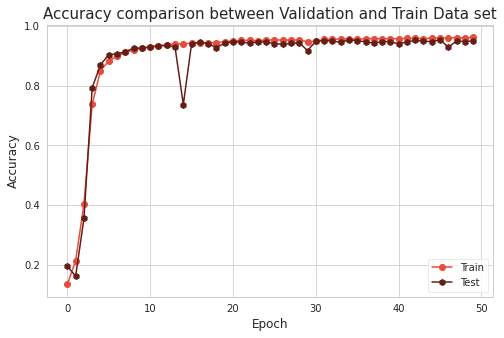

In [ ]:
acc_plot(vgg_adamW)

**4. Visualizing loss in every epoch**

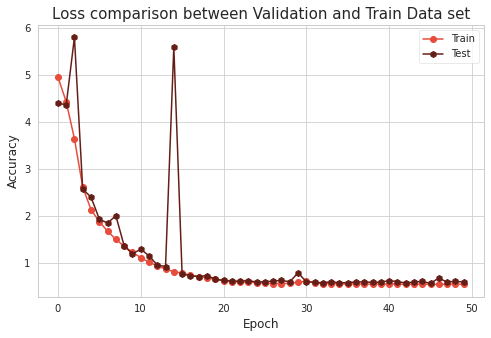

In [ ]:
loss_plot(vgg_adamW)

**5. Visualizing Confusion Matrix**

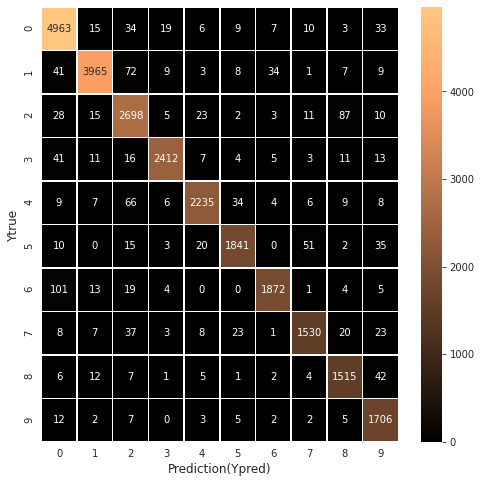

In [ ]:
display_cm(y_test, pred)

**6. Roc Curve**

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
y_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_bin.shape[1]
y_pred = label_binarize(pred, classes=[0,1,2,3,4,5,6,7,8,9])

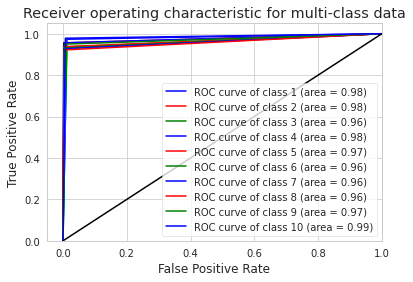

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

**End.**